# Train model to recognise voice of people 

In [147]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
from enum import Enum
import pandas as pd
from pathlib import Path
from torchvision.transforms.functional import normalize
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [148]:
def filter_sample_by_clients_ids(data: pd.DataFrame, max_count: int = 500, min_count: int = 4):
	sample_count = data['client_id'].value_counts()
	clients_ids = [e for e in sample_count[sample_count < max_count][sample_count > min_count].index]
	return data[data['client_id'].isin(clients_ids)]

def concatenation(train_data: pd.DataFrame, anchor: pd.DataFrame, posneg: pd.DataFrame) -> pd.DataFrame:
		data_particle_case = pd.DataFrame(columns=['anchor_client_id', 'anchor_path', 'posneg_client_id', 'posneg_path', 'anchor_source', 'posneg_source'])
		data_particle_case[['anchor_client_id', 'anchor_path', 'anchor_source']] = anchor
		data_particle_case[['posneg_client_id', 'posneg_path', 'posneg_source']] = posneg
		return pd.concat([train_data, data_particle_case], ignore_index=True)

def generate_combined_dataset(original_data: pd.DataFrame, generated_data: pd.DataFrame, data_frac: int = 0.5) -> pd.DataFrame:
	client_ids = original_data['client_id'].unique()
	original_data['source'] = 'original'
	generated_data['source'] = 'generated'
	
	train_data = pd.DataFrame(columns=['anchor_client_id', 'anchor_path', 'posneg_client_id', 'posneg_path', 'anchor_source', 'posneg_source'])
	for id in client_ids:

		original_id_sample = original_data[original_data['client_id'] == id]
		generated_id_sample = generated_data[generated_data['client_id'] == id]
		original_no_client_id_sample = original_data[original_data['client_id'] != id]

		anchor_original = original_id_sample.sample(frac=data_frac).reset_index(drop=True)
		positive_original = original_id_sample.sample(frac=data_frac).reset_index(drop=True)
		train_data = concatenation(train_data, anchor_original, positive_original)


		anchor_original = original_id_sample.sample(frac=data_frac).reset_index(drop=True)
		negative_original = original_no_client_id_sample.sample(frac=data_frac).reset_index(drop=True)
		train_data = concatenation(train_data, anchor_original, negative_original)

		anchor_original = original_id_sample.sample(frac=data_frac).reset_index(drop=True)
		positive_original = original_id_sample.sample(frac=data_frac).reset_index(drop=True)
		train_data = concatenation(train_data, anchor_original, positive_original)

		anchor_original = original_id_sample.sample(frac=data_frac).reset_index(drop=True)
		negative_generated = generated_id_sample.sample(frac=data_frac).reset_index(drop=True)
		train_data = concatenation(train_data, anchor_original, negative_generated)
	
	return train_data

In [149]:
import librosa

from src.columns.combined_dataset_column import CombinedDatasetColumn
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, ToMelSpectrogramTransform
import torch
from torch.utils.data import Dataset

from src.transform.composite_transformation import CompositeTransformation


class CombinedMixedSoundDS(Dataset):
	def __init__(
		self,
		voiceOriginalDataset,
		voiceGeneratedDataset,
		original_voice_data_path,
		generated_voice_data_path,
		sample_rate=16000,
		duration=3,
		transform=None
	):
		self.voiceOriginalDataset = voiceOriginalDataset
		self.voiceGeneratedDataset = voiceGeneratedDataset
		self.original_voice_data_path = str(original_voice_data_path)
		self.generated_voice_data_path = str(generated_voice_data_path)
		self.duration = duration
		self.sample_rate = sample_rate
		self.transform = None
		if transform is not None:
			self.transform = transform
		else:
			self.transform = CompositeTransformation(
				[
					ResampleTransform(target_sample_rate=sample_rate),
					CustomAdjustDurationTransform(duration_seconds=duration),
					ToMelSpectrogramTransform(
						sample_rate=sample_rate, n_mels=64, n_fft=512)
				]
			)
		self.mix_dataset()

	def __len__(self):
		return len(self.temp_dataset)

	def _get_sgram(self, audio_file):
		audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
		spectrogram = self.transform.transform((audio, sample_rate))
		spectrogram = spectrogram.unsqueeze(0)
		return spectrogram

	def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
		label = anchor_client_id == posneg_client_id and anchor_source == posneg_source
		return torch.tensor(0 if label else 1, dtype=torch.int64)

	def _get_sample_path(self, path, source):
		data_path = self.original_voice_data_path if source == 'original' else self.generated_voice_data_path
		return data_path + path

	def mix_dataset(self):
		print("mix")
		clean_origin_data = filter_sample_by_clients_ids(self.voiceOriginalDataset)[['client_id', 'path']]
		clean_generated_data = filter_sample_by_clients_ids(self.voiceGeneratedDataset)[['client_id', 'generated_path']]
		self.temp_dataset = generate_combined_dataset(clean_origin_data, clean_generated_data, data_frac=1)
		self.reset_iteration()
		  
	def reset_iteration(self):
		self.iteration_to_mix = len(self.temp_dataset)
	def __getitem__(self, idx):
		anchor_path, posneg_path, anchor_client_id, posneg_client_id, anchor_source, posneg_source = self.temp_dataset.iloc[idx][
			[
				CombinedDatasetColumn.ANCHOR_PATH,
				CombinedDatasetColumn.POSNEG_PATH,
				CombinedDatasetColumn.ANCHOR_ID,
				CombinedDatasetColumn.POSNEG_ID,
				CombinedDatasetColumn.SOURCE_ANCHOR,
				CombinedDatasetColumn.SOURCE_POSNEG
			]
		].values.tolist()

		anchor_file = self._get_sample_path(anchor_path, anchor_source)
		posneg_file = self._get_sample_path(posneg_path, posneg_source)
		label = self._get_label(
			anchor_client_id, posneg_client_id, anchor_source, posneg_source)
		anchor_sgram = self._get_sgram(anchor_file)
		posneg_sgram = self._get_sgram(posneg_file)
		self.iteration_to_mix -= 1
		if self.iteration_to_mix == 0:
			self.mix_dataset()
		return anchor_sgram, posneg_sgram, label

In [150]:
class DS(CombinedSoundDS):
	def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
		label = anchor_client_id == posneg_client_id and anchor_source == posneg_source
		return torch.tensor(0 if label else 1, dtype=torch.int64)

In [151]:

DATASET_PATH = './data/'
DATA_PATH = './data/'
MODEL_SAVE_PATH = './model_save/'
SAMPLE_RATE = 16000

In [152]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform, ToMelSpectrogramTransform, AirAbsorptionWrapperTransform, EqualizerWrapperTransform
from src.transform.composite_transformation import CompositeTransformation

train_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
		AirAbsorptionWrapperTransform(),
		EqualizerWrapperTransform(),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)

test_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
		AirAbsorptionWrapperTransform(),
		EqualizerWrapperTransform(),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)

In [153]:
original = pd.read_csv(DATASET_PATH + "validated.tsv",  sep='\t')
generated = pd.read_csv(DATASET_PATH + "generated.tsv",  sep='\t')

In [154]:
train_ds = CombinedMixedSoundDS(voiceOriginalDataset=original, voiceGeneratedDataset=generated, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform=test_transform)

mix


In [155]:
class SiameseNetwork(nn.Module):
		def __init__(self):
				super(SiameseNetwork, self).__init__()
				self.conv_layers = nn.Sequential(
						nn.Conv2d(1, 32, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(32, 64, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(64, 128, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(128, 256, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
				)
				self.fc_layers = nn.Sequential(
						nn.Linear(4608, 1024),
						nn.ReLU(inplace=True),
				)

				self.final = nn.Linear(1024, 2)

		def forward_once(self, x):

				x = self.conv_layers(x)
				x = x.view(x.size(0), -1)
				x = self.fc_layers(x)
				return x

		def forward(self, input1, input2):
			output1 = self.forward_once(input1)
			output2 = self.forward_once(input2)
			return self.final(torch.abs(output1 - output2))

In [156]:
num_items = len(train_ds)
num_train = round(num_items * 0.4)
num_val = num_items - num_train
train_ds, val_ds = random_split(train_ds, [num_train, num_val])


In [157]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=24, shuffle=True)
#test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

In [158]:

import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm


def evaluate_siamese_model_contrast_loss(model, dataloader, criterion, device='cpu'):
	model.eval()
	total_loss = 0.0
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			anchor_output, posneg_output = model(anchor_sgram, posneg_sgram)
			loss = criterion(anchor_output, posneg_output, label)
			total_loss += loss.item()

			true_labels += [label.item() for label in label.cpu()]


	avg_loss = total_loss / len(dataloader)

	return avg_loss

In [159]:
def train_siamese_model_contrast_loss(model, dataloader, criterion, optimizer, device='cpu'):
	model.train()
	total_loss = 0.0
	true_labels = []

	for batch in tqdm(dataloader, desc="Training", leave=False):
		anchor_sgram, posneg_sgram, label = batch
		anchor_sgram = anchor_sgram.to(device)
		posneg_sgram = posneg_sgram.to(device)
		label = label.to(device)
		optimizer.zero_grad()
		anchor_output, posneg_output = model(anchor_sgram, posneg_sgram)
		loss = criterion(anchor_output, posneg_output, label)
		loss.backward()
		optimizer.step()
		total_loss += loss.item()
		true_labels += [label.item() for label in label.cpu()]

	avg_loss = total_loss / len(dataloader)
	
	return avg_loss

In [160]:
class ContrastiveLoss(torch.nn.Module):
	def __init__(self, margin=2.0):
		super(ContrastiveLoss, self).__init__()
		self.margin = margin

	def forward(self, output1, output2, label):
		euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
		loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
									  (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
		return loss_contrastive

In [161]:
num_epochs = 5
siamese_model = SiameseNetwork().to('cuda')
criterion = ContrastiveLoss().to('cuda')
optimizer = optim.Adam(siamese_model.parameters(), lr=0.00001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [162]:
loss, accuracy, precision, recall, f1 = [], [], [], [], []
for epoch in range(num_epochs):
	_train_loss = train_siamese_model_contrast_loss(siamese_model, train_dl, criterion, optimizer, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_train_loss:.4f}")
	#_test_loss = evaluate_siamese_model_contrast_loss(siamese_model, test_dl, criterion, device)
	#print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_test_loss:.4f}")
	#loss.append([_train_loss, _test_loss])

Epoch 1/2, Loss: 100.5539


Epoch 2/2, Loss: 67.4851


In [163]:
def save_model(model, model_name, base_path = './model_save/'):
	model.cpu()
	model.eval()
	torch.save(model, base_path + model_name)

In [164]:
save_model(siamese_model, "contrast_cnn.pt")

In [165]:
from matplotlib import pyplot as plt


def plot_siamese_model(anchor_sgram, posneg_sgram, label, loss):
	plt.style.use("dark_background")
	plt.figure(figsize=(10, 2), facecolor="#1e1e1e")
	plt.subplot(1, 2, 1)
	plt.title("Anchor Sgram")
	plt.imshow(anchor_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	type = "Positive" if label.item() == 0 else "Negative"
	plt.title(f"{type} Sgram")
	plt.imshow(posneg_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	plt.show()
	print(f"Similarity: {loss}")

In [166]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


def evaluate(model, anchor_sgram, posneg_sgram, label):
	model.eval()
	model.to(device)
	with torch.no_grad():
		anchor_sgram = anchor_sgram.unsqueeze(0).to(device)
		posneg_sgram = posneg_sgram.unsqueeze(0).to(device)
		label = label.to(device)
		anchor_output, posneg_output = model(anchor_sgram, posneg_sgram)
		loss = F.pairwise_distance(anchor_output, posneg_output, keepdim = True)
	label.cpu()
	return loss.item()

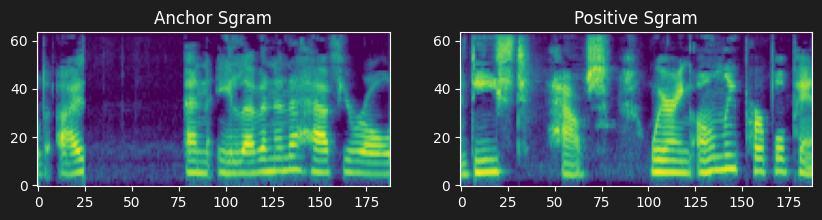

Similarity: 12.038724899291992


In [182]:
anchor_sgram, posneg_sgram, label = train_ds[1]
loss = evaluate(siamese_model, anchor_sgram, posneg_sgram, label)
plot_siamese_model(anchor_sgram.squeeze(0), posneg_sgram.squeeze(0), label, loss)

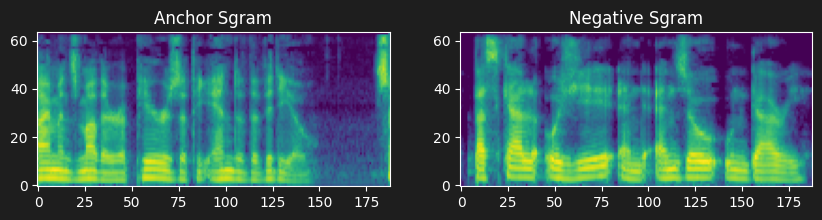

Similarity: 10.417865753173828


In [190]:
anchor_sgram, posneg_sgram, label = train_ds[5]
loss = evaluate(siamese_model, anchor_sgram, posneg_sgram, label)
plot_siamese_model(anchor_sgram.squeeze(0), posneg_sgram.squeeze(0), label, loss)

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np

def train_classifier(model, dataloader):
	model.eval()
	true_labels = []
	predicted_loss = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			anchor_output, posneg_output = model(anchor_sgram, posneg_sgram)
			distances = torch.mean(F.pairwise_distance(anchor_output, posneg_output, keepdim = True), dim=1, keepdim=True)

			true_labels += [label.item() for label in label.cpu()]
			predicted_loss += [distance.item() for distance in distances.cpu()]

	return true_labels, predicted_loss

In [192]:
true_labels, predicted_loss = train_classifier(siamese_model, train_dl)

Evaluating:  49%|████▉     | 134/272 [01:26<01:36,  1.42it/s]

mix


In [193]:
X = np.array(predicted_loss).reshape(-1, 1)
y = np.array(true_labels)

In [194]:
reg = LogisticRegression().fit(X, y)

In [195]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [196]:
p = reg.predict(X)

In [198]:
accuracy_score(y, p)

0.5413689790274256